In [93]:
import time

import pandas as pd 
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets as ds
from sklearn import neighbors, svm, tree, linear_model, ensemble, neural_network, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, f1_score, confusion_matrix, accuracy_score

%matplotlib inline
# plt.style.use('bmh')

pd.set_option("max_columns",90, "max_rows", 90)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [169]:
raw_df = pd.read_csv('Gse_panel_current_sample_raw.csv')
# raw_df.head()

In [ ]:
# check missing data
(~raw_df.isna()).sum()

# fill the missing msa
# missing msa --> corresponding prop_state x
# prop_state x --> find the most frequent msa in that state ==> sta_msa, a dict {state_name: most frequent msa in that state}
# use sta_msa to fill in the missing msa
sta_msa = {}
for state, group in raw_df[['prop_state', 'msa']].groupby('prop_state'):
    sta_msa[state] = group['msa'].value_counts().idxmax()
raw_df['msa'] = raw_df[['prop_state', 'msa']].apply(lambda row: sta_msa[row['prop_state']] if np.isnan(row['msa']) else row['msa'], axis = 1)

# fill in the missing num_bo and num_unit with their median respectively 
raw_df['num_bo'].fillna(raw_df['num_bo'].median(), inplace=True)
raw_df['num_unit'].fillna(raw_df['num_unit'].median(), inplace=True)

# drop the obeservations with missing data in status column
df = raw_df.dropna(how='any').copy()                                           

# double check
(~raw_df.isna()).sum()

In [ ]:
df['status'] = df['status'].apply(lambda x: int(x=='D60-D90'))
X = df.drop(['loan_id', 'status', 'status_prev', 'prop_state'], axis=1).copy()
y = df['status'].copy()

## Countplot of target variable

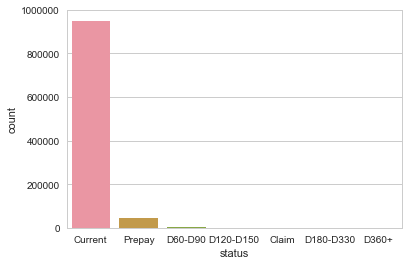

In [184]:
sns.countplot(x='status', data=df)

orig_rt          0.154013
orig_upb         1.216275
oltv            -1.011030
dti              0.115911
fico            -0.870040
ind_ede          1.111356
pmms_o          -0.149889
avg_upb          1.109308
OUPB_Rel         0.839974
loan_age_qtr     1.357259
PMMS             0.342397
HPI_O            0.826645
HPI              0.956029
ur               0.982894
CUPB_calc        1.242500
Orig_value      14.950838
CLTV             0.054055
dtype: float64
orig_rt         0.154013
orig_upb        1.216275
oltv           -1.011030
dti             0.115911
fico           -0.870040
ind_ede         1.111356
pmms_o         -0.149889
avg_upb         1.109308
OUPB_Rel        0.839974
loan_age_qtr    1.357259
PMMS            0.342397
HPI_O           0.826645
HPI             0.956029
ur              0.982894
CUPB_calc       1.242500
Orig_value      0.020877
CLTV            0.054055
dtype: float64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

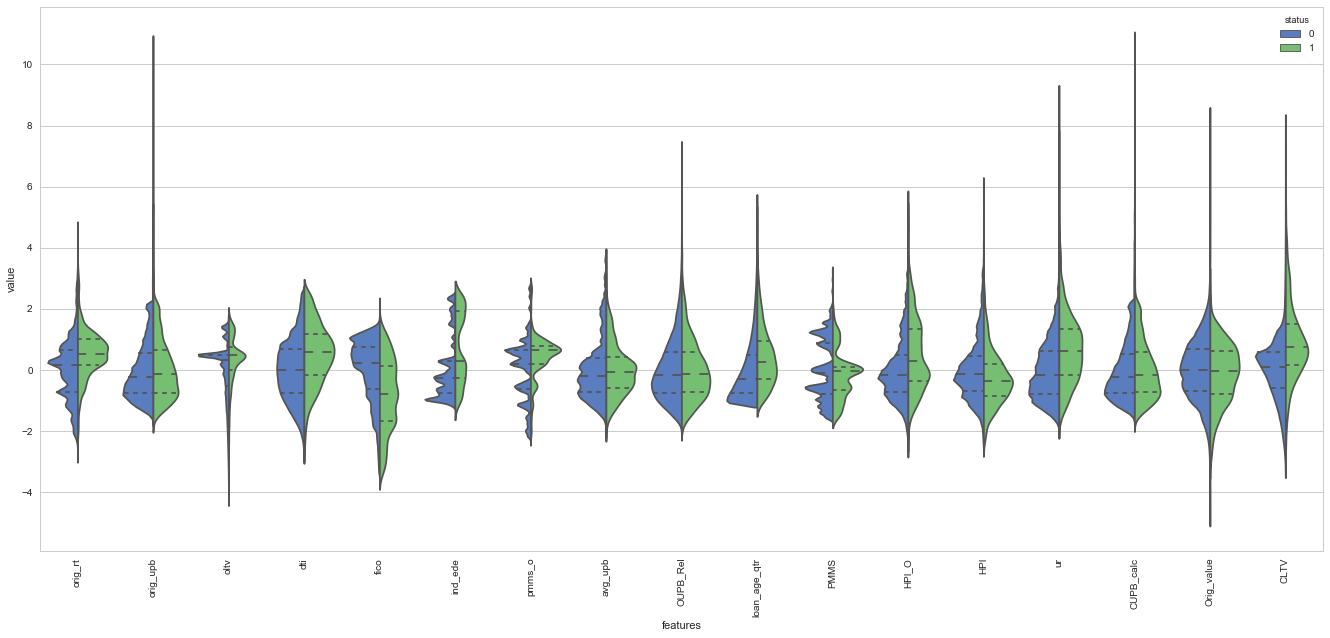

In [188]:
X_num = X.select_dtypes(include=['float64', 'int64']).copy()  # 24 features of numerical data type

X_num.drop(['num_bo', 'num_unit', 'oyr', 'oqtr', 'year', 'qtr', 'msa'], axis=1, inplace=True)

# measure skewness of features
skewed_features = X_num.skew()
skewed_idx = skewed_features[skewed_features.abs() > 2].index
print(skewed_features)

# perform log transformation to the highly skewed features
X_num[skewed_idx] = X_num[skewed_idx].transform(np.log)

# 
skewed_features = X_num.skew()
print(skewed_features)

X_num_nmlz = (X_num - X_num.mean()) / X_num.std()


# voilinplot
group_all = pd.concat([y, X_num_nmlz], axis=1)
group_all = pd.melt(group_all, id_vars="status", var_name="features", value_name='value')
plt.figure(figsize=(23, 10))
sns.violinplot(x="features", y="value", hue="status", data=group_all, split=True, inner="quart")
plt.xticks(rotation=90)

Accuracy is:  0.9978389734593401


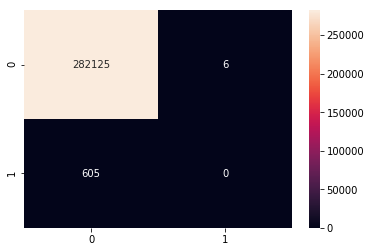

In [13]:
# convert the categorical vars to binary vars
X = pd.get_dummies(X)

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train, y_train)

ac = accuracy_score(y_test, clf_rf.predict(x_test))
print('Accuracy is: ', ac)
cm = confusion_matrix(y_test, clf_rf.predict(x_test))
sns.heatmap(cm, annot=True, fmt="d")

### Overlapping density plot

## Feature Selection

In [31]:
# Filter Methods - chi2: may not be applicable
# find best scored 10 features
select_feature = SelectKBest(chi2, k=10).fit(x_train, y_train)
score = np.vstack((x_train.columns, np.array(select_feature.scores_)))
score = score[:, score[1].argsort()]
score[:, ::-1]

Optimal number of features : 35
Best features : Index(['orig_rt', 'orig_upb', 'oltv', 'num_bo', 'dti', 'msa', 'fico', 'oyr',
       'oqtr', 'ind_ede', 'pmms_o', 'avg_upb', 'OUPB_Rel', 'loan_age_qtr',
       'year', 'qtr', 'PMMS', 'HPI_O', 'HPI', 'ur', 'CUPB_calc', 'Orig_value',
       'CLTV', 'orig_chn_B', 'orig_chn_C', 'orig_chn_R', 'orig_chn_T',
       'loan_purp_C', 'loan_purp_P', 'loan_purp_R', 'prop_type_CO',
       'prop_type_PU', 'prop_type_SF', 'occ_stat_O', 'occ_stat_P'],
      dtype='object')


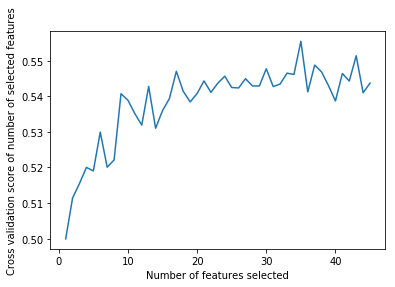

In [41]:
# Wrapper Methods - Recursive Feature elimination
estimator  = RandomForestClassifier()      
rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(10), step=1, scoring='roc_auc')
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
# Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features
    # To use feature_importance method, in training data there should not be correlated features. 
    # Random forest choose randomly at each iteration, therefore sequence of feature importance list can change.


In [43]:
x_train.columns[~rfecv.support_]

Index(['num_unit', 'loan_purp_N', 'loan_purp_U', 'prop_type_CP',
       'prop_type_LH', 'prop_type_MH', 'occ_stat_I', 'occ_stat_S',
       'fhb_flag_N', 'fhb_flag_Y'],
      dtype='object')